In [2]:
#importing basic required libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#import image processing related libraries
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split

class RingwormDataPreprocessor:
    def __init__(self, dataset_path, output_dir='preprocessed_data', img_size=(224, 224)):
        """
        Initialize the preprocessor with dataset parameters.

        Args:
            dataset_path (str): Path to the dataset folder (already extracted).
            output_dir (str): Directory to save preprocessed data.
            img_size (tuple): Target image size for deep learning models.
        """
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        self.img_size = img_size
        
        # Create necessary directories
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'augmented_images'), exist_ok=True)
    
    def preprocess_images(self):
        """
        Preprocess images: Resize, normalize, apply augmentations, and save.
        """
        # Preprocessing and augmentation pipeline
        preprocessing_transform = A.Compose([
            A.Resize(width=self.img_size[0], height=self.img_size[1]),  # Resize
            A.RandomBrightnessContrast(p=0.3),  # Adjust brightness & contrast
            A.HueSaturationValue(p=0.3),  # Modify hue & saturation
            A.HorizontalFlip(p=0.5),  # Flip horizontally
            A.VerticalFlip(p=0.2),  # Flip vertically
            A.Rotate(limit=30, p=0.3),  # Rotate by ±30 degrees
            A.Normalize(  # Normalize using ImageNet mean/std
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0
            )
        ])
        
        image_data = []  # Store metadata
        
        # Iterate through dataset images
        for class_folder in os.listdir(self.dataset_path):
            class_path = os.path.join(self.dataset_path, class_folder)
            if not os.path.isdir(class_path):
                continue  # Skip non-folder files

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                try:
                    # Read the image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB
                    
                    # Apply preprocessing
                    preprocessed = preprocessing_transform(image=img)['image']
                    
                    # **Fix: Ensure pixel values are in the correct range**
                    preprocessed = np.clip(preprocessed, 0, 1)  # Scale to 0-1
                    
                    # Define output path
                    output_img_path = os.path.join(
                        self.output_dir, 
                        'augmented_images', 
                        f'{class_folder}_{img_name}'
                    )
                    
                    # Save the image (Two Methods: Choose One)
                    plt.imsave(output_img_path, preprocessed)  # ✅ Option 1: Matplotlib
                    
                    # Alternative (More Robust)
                    # preprocessed = (preprocessed * 255).astype(np.uint8)
                    # cv2.imwrite(output_img_path, cv2.cvtColor(preprocessed, cv2.COLOR_RGB2BGR))  # ✅ Option 2: OpenCV
                    
                    # Store metadata
                    image_data.append({
                        'filename': img_name,
                        'class': class_folder,
                        'original_path': img_path,
                        'preprocessed_path': output_img_path
                    })
                
                except Exception as e:
                    print(f"❌ Error processing {img_path}: {e}")
        
        # Save metadata
        metadata_df = pd.DataFrame(image_data)
        metadata_df.to_csv(os.path.join(self.output_dir, 'image_metadata.csv'), index=False)
        
        return metadata_df
    
    def generate_class_distribution_plot(self, metadata_df):
        """
        Generate and save class distribution plot.
        """
        plt.figure(figsize=(10, 6))
        metadata_df['class'].value_counts().plot(kind='bar')
        plt.title('Class Distribution in Ringworm Dataset')
        plt.xlabel('Disease Class')
        plt.ylabel('Number of Images')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'class_distribution.png'))
        plt.close()
    
    def create_train_test_split(self, metadata_df, test_size=0.2, random_state=42):
        """
        Split data into training and testing sets.
        """
        train_df, test_df = train_test_split(
            metadata_df, 
            test_size=test_size, 
            stratify=metadata_df['class'], 
            random_state=random_state
        )
        
        train_df.to_csv(os.path.join(self.output_dir, 'train_metadata.csv'), index=False)
        test_df.to_csv(os.path.join(self.output_dir, 'test_metadata.csv'), index=False)
        
        return train_df, test_df

# Usage Example
def main():
    # ✅ Set dataset path
    dataset_path = "/kaggle/input/ringworm-dataset-for-classification"  
    
    # Initialize preprocessor
    preprocessor = RingwormDataPreprocessor(dataset_path)
    
    # Preprocess images
    metadata_df = preprocessor.preprocess_images()
    
    # Generate class distribution plot
    preprocessor.generate_class_distribution_plot(metadata_df)
    
    # Create train-test split
    train_df, test_df = preprocessor.create_train_test_split(metadata_df)
    
    print("✅ Preprocessing complete!")

if __name__ == '__main__':
    main()


✅ Preprocessing complete!


                 filename     class  \
0  Pasted image (161).png  Ringworm   
1   Pasted image (76).png  Ringworm   
2  Pasted image (104).png  Ringworm   
3  Pasted image (177).png  Ringworm   
4  Pasted image (143).png  Ringworm   

                                       original_path  \
0  /kaggle/input/ringworm-dataset-for-classificat...   
1  /kaggle/input/ringworm-dataset-for-classificat...   
2  /kaggle/input/ringworm-dataset-for-classificat...   
3  /kaggle/input/ringworm-dataset-for-classificat...   
4  /kaggle/input/ringworm-dataset-for-classificat...   

                                   preprocessed_path  
0  preprocessed_data/augmented_images/Ringworm_Pa...  
1  preprocessed_data/augmented_images/Ringworm_Pa...  
2  preprocessed_data/augmented_images/Ringworm_Pa...  
3  preprocessed_data/augmented_images/Ringworm_Pa...  
4  preprocessed_data/augmented_images/Ringworm_Pa...  


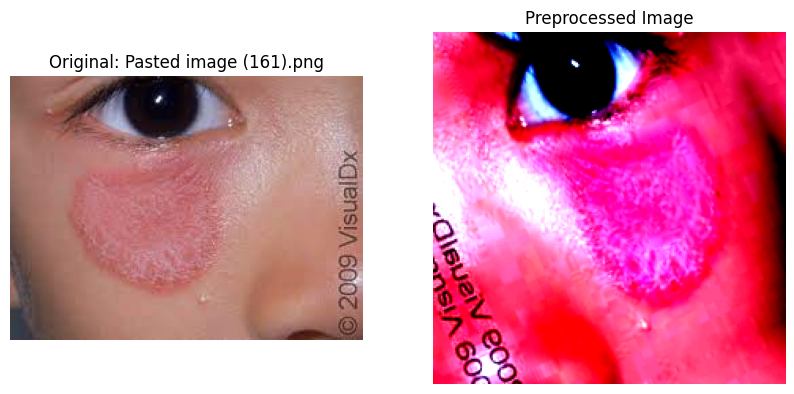

Press Enter to view next comparison... 


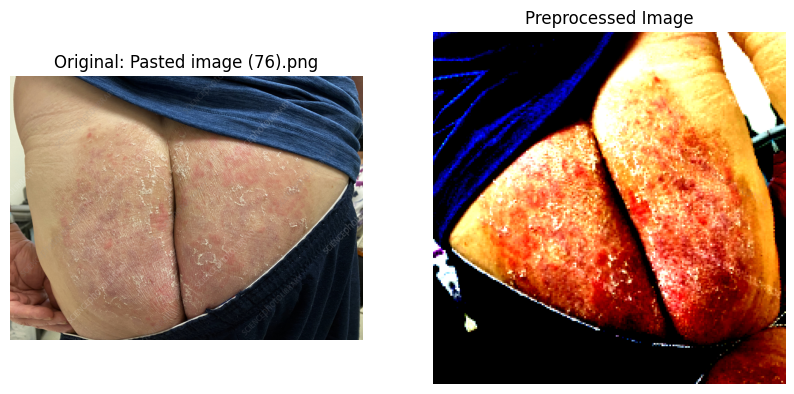

Press Enter to view next comparison... 


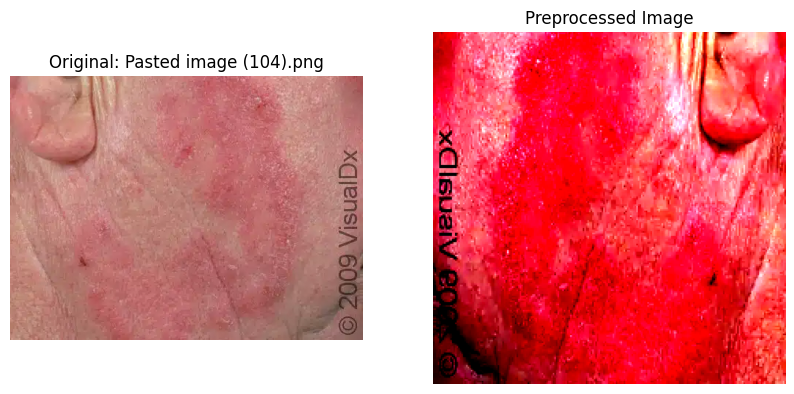

Press Enter to view next comparison... 


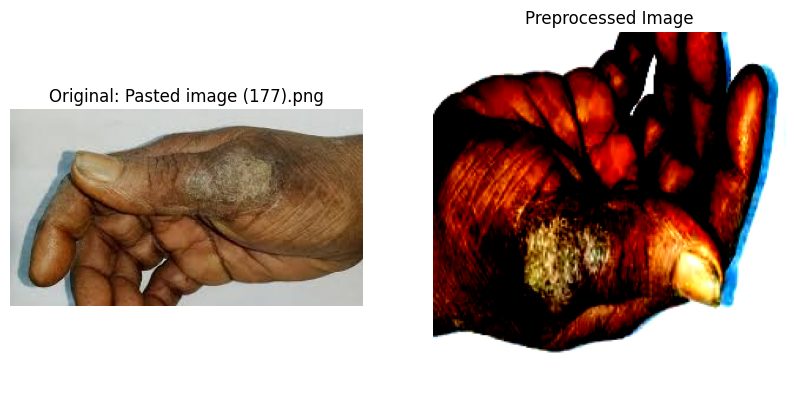

Press Enter to view next comparison... 


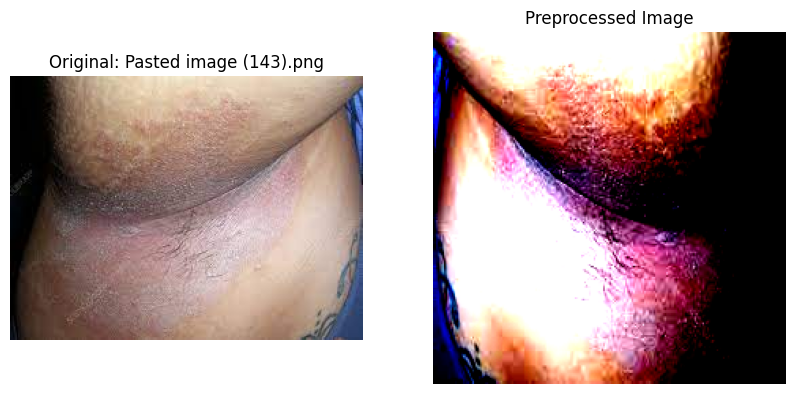

Press Enter to view next comparison... 


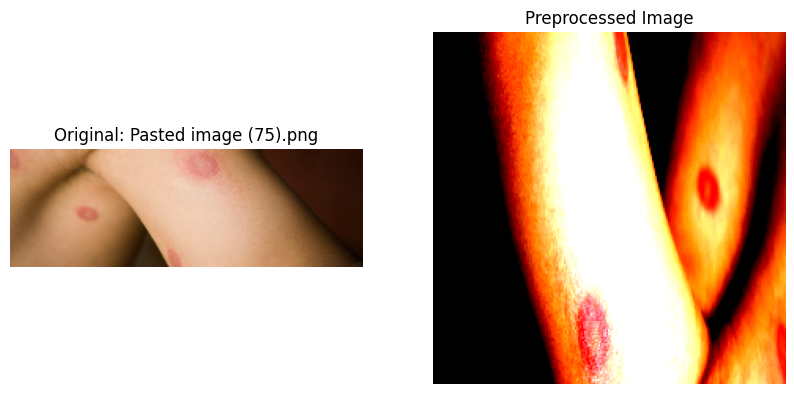

Press Enter to view next comparison... 


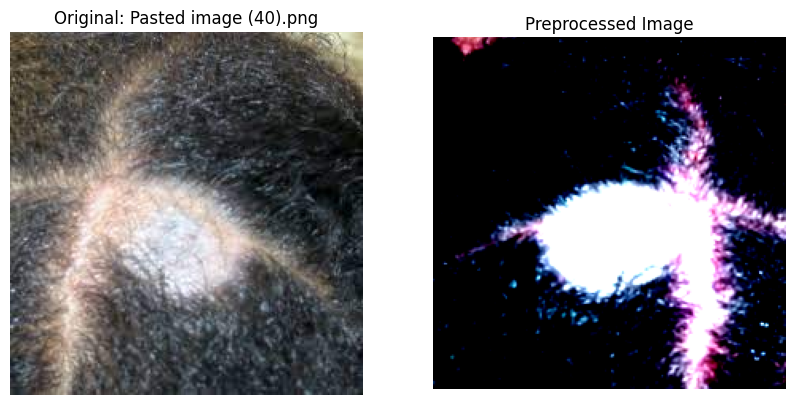

Press Enter to view next comparison... 


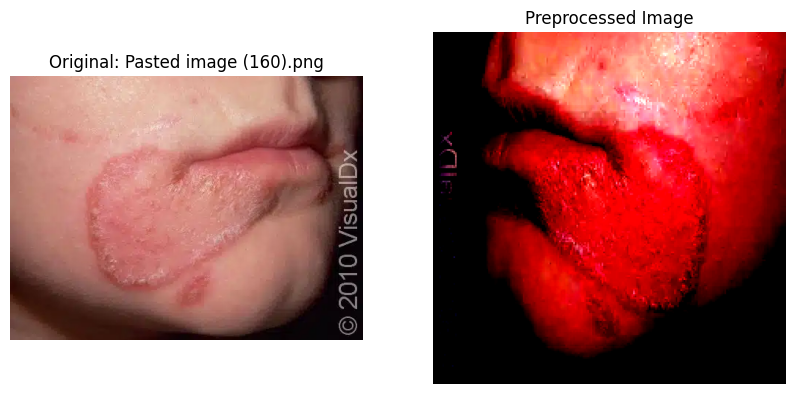

Press Enter to view next comparison... 


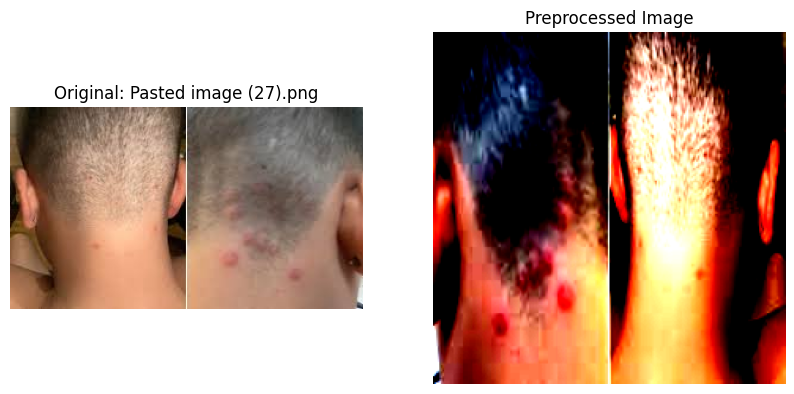

Press Enter to view next comparison... 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# ✅ Load the CSV file containing metadata
csv_path = "/kaggle/working/preprocessed_data/image_metadata.csv"
df = pd.read_csv(csv_path)

# ✅ Display a few rows to ensure correct loading
print(df.head())

# ✅ Loop through images and display original vs. preprocessed images
for index, row in df.iterrows():
    original_img_path = row["original_path"]
    preprocessed_img_path = row["preprocessed_path"]

    # Check if files exist to avoid errors
    if not os.path.exists(original_img_path) or not os.path.exists(preprocessed_img_path):
        print(f"⚠ Skipping {original_img_path} or {preprocessed_img_path} (Invalid Path)")
        continue
    
    # Read images
    original_img = cv2.imread(original_img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    preprocessed_img = cv2.imread(preprocessed_img_path)
    preprocessed_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Plot both images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # ✅ Show Original Image
    axes[0].imshow(original_img)
    axes[0].axis("off")
    axes[0].set_title(f"Original: {row['filename']}")

    # ✅ Show Preprocessed Image
    axes[1].imshow(preprocessed_img)
    axes[1].axis("off")
    axes[1].set_title("Preprocessed Image")

    plt.show()

    # Optional: Pause for user input before showing the next images
    input("Press Enter to view next comparison...")  
